In [ ]:
# run this script undere domino standard > 5.7 
!pip install statannotations openpyxl nibabel seaborn boto3==1.35.20 fsspec s3fs==2024.9.0
!{'sudo apt-get install -y sshpass awscli'}

In [1]:
import numpy as np
import pandas as pd
import shutil, itertools , glob , os ,csv, re, itertools
from scipy.stats import pearsonr
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns # --> Restart Kernel
import nibabel as nb
from statannotations.Annotator import Annotator

### Data Path

In [2]:
path_data = '/domino/edv/nfs-pvc/taupet/'
study_name = 'ADNIpet'
output_proc = 'Proc.domino.v1'
file_to_read = '/best/1Dstats/aparc.a2009s+aseg_rank.al.mid.PET.SUV.T807.BL.al.mid.Cerebellum.cortex.suvr.avg.stats.1D'

### Reading the Diagnosis File

In [3]:
# Read diagnosis file
diag_file_tmp = pd.read_excel('/mnt/early_scripts/ADNI-Diag_TW.xlsx')

# Filter for baseline visits, rename columns, and drop duplicates
diag_file_tmp = diag_file_tmp.loc[diag_file_tmp['TAUPET_avisit']=='BL',:]
diag_file = diag_file_tmp.rename(columns={'sub':'sid','BL.nsb.diag':'diag'})\
                [['sid','diag', 'TAUPET_avisit' , 'BL.AmyloidStatus','BL.nsb.age']]\
                .drop_duplicates('sid')\
                .reset_index(drop=True)

# Filter subjects with amyloid status
diag_file = diag_file[diag_file['BL.AmyloidStatus'].isin(['pos','neg'])]

# change the dignosis 
dict_pos_neg={'pos':'+', 'neg':'-'}
diag_file['BL.AmyloidStatus_new'] = diag_file['BL.AmyloidStatus'].map(dict_pos_neg)
diag_file['diag_status'] = diag_file['diag'] + diag_file['BL.AmyloidStatus_new']

# Exclude AD negative because of statistical power
diag_file_noADneg = diag_file[~(diag_file['diag_status']=='AD-')]

# Get list of subject IDs and count
subjects_list = diag_file_noADneg['sid'].tolist()
len(subjects_list)

753

### Demographic of Subjects

In [4]:
#diag_file.groupby('diag').count()
#diag_file[['sid','diag','BL.AmyloidStatus']].groupby(['diag','BL.AmyloidStatus']).count()
#diag_file[['diag','BL.nsb.age']].groupby('diag').mean().round()
#diag_file[['diag','BL.nsb.age']].groupby('diag').std().round()

### Braak Areas

In [5]:
Braak_areas = {
    'Braak_1':['ctx-lh-entorhinal',
               'ctx-rh-entorhinal'],
    
    'Braak_2':['Right-Hippocampus',
               'Left-Hippocampus'],
    
    'Braak_3':[ 'ctx-lh-parahippocampal',
                'ctx-rh-parahippocampal',
                'ctx-lh-fusiform',
                'ctx-rh-fusiform',
                'ctx-lh-lingual',
                'ctx-rh-lingual',
                'Left-Amygdala',
                'Right-Amygdala'],
    
    'Braak_4':[ 'ctx-lh-middletemporal',
                'ctx-rh-middletemporal',          
                'Left-Thalamus',  #'Left-Thalamus-Proper' does not exit
                'Right-Thalamus', #'Right-Thalamus-Proper' does not exit
                'ctx-lh-caudalanteriorcingulate',
                'ctx-rh-caudalanteriorcingulate',
                'ctx-lh-rostralanteriorcingulate',
                'ctx-rh-rostralanteriorcingulate',
                'ctx-lh-posteriorcingulate',
                'ctx-rh-posteriorcingulate',   
                'ctx-lh-isthmuscingulate',
                'ctx-rh-isthmuscingulate',    
                'ctx-lh-insula',
                'ctx-rh-insula',                
                'ctx-lh-inferiortemporal',
                'ctx-rh-inferiortemporal',      
                'ctx-lh-temporalpole',
                'ctx-rh-temporalpole'],
    
    'Braak_5':['ctx-lh-superiorfrontal',
                'ctx-rh-superiorfrontal',
                'ctx-lh-lateralorbitofrontal',
                'ctx-rh-lateralorbitofrontal',
                'ctx-lh-medialorbitofrontal',
                'ctx-rh-medialorbitofrontal',
                'ctx-lh-frontalpole',
                'ctx-rh-frontalpole',         
                'ctx-lh-caudalmiddlefrontal',
                'ctx-rh-caudalmiddlefrontal',
                'ctx-lh-rostralmiddlefrontal',
                'ctx-rh-rostralmiddlefrontal',
                'ctx-lh-parsopercularis',
                'ctx-rh-parsopercularis',     
                'ctx-lh-parsorbitalis',
                'ctx-rh-parsorbitalis',       
                'ctx-lh-parstriangularis',
                'ctx-rh-parstriangularis',
                'Left-Caudate',
                'Right-Caudate',              
                'Left-Putamen',
                'Right-Putamen',              
                'ctx-lh-lateraloccipital',
                'ctx-rh-lateraloccipital',    
                'ctx-lh-supramarginal',
                'ctx-rh-supramarginal',    
                'ctx-lh-inferiorparietal',
                'ctx-rh-inferiorparietal',    
                'ctx-lh-superiortemporal',
                'ctx-rh-superiortemporal',
                'Left-Pallidum',
                'Right-Pallidum',             
                'ctx-lh-superiorparietal',
                'ctx-rh-superiorparietal',    
                'ctx-lh-precuneus',
                'ctx-rh-precuneus',           
                'ctx-lh-bankssts',
                'ctx-rh-bankssts',            
                'Left-Accumbens-area',
                'Right-Accumbens-area',       
                'ctx-lh-transversetemporal',
                'ctx-rh-transversetemporal'],
    
    'Braak_6':['ctx-lh-pericalcarine',
                'ctx-rh-pericalcarine',
                'ctx-lh-postcentral',
                'ctx-rh-postcentral',
                'ctx-lh-cuneus',
                'ctx-rh-cuneus',      
                'ctx-lh-precentral',
                'ctx-rh-precentral',
                'ctx-lh-paracentral',  
                'ctx-rh-paracentral']}


Braak_areas_list = list(itertools.chain.from_iterable(list(Braak_areas.values())))

### Convert SUVR_1D file to Braak

In [6]:
 def suvr_1d_to_braak(proc_path, sid, file_to_read):
    
    # creating the proc path
    suvr_1d_file = proc_path + '/' + sid + '/' + file_to_read

    braak_areas_suvr={'sid': sid}
    if os.path.exists(suvr_1d_file):
        suvr_data = pd.read_csv(suvr_1d_file, delimiter='\t')

        # selecting the mean value for each regions    
        suvr_data_nzmean = suvr_data[suvr_data.columns[suvr_data.columns.str.contains('NZMean')]]
        suvr_data_nzcount = suvr_data[suvr_data.columns[suvr_data.columns.str.contains('NZcount')]]

        # remove NZmean from column name
        suvr_data_nzmean.columns = suvr_data_nzmean.columns.str[7:]
        suvr_data_nzcount.columns = suvr_data_nzcount.columns.str[8:]

        # check all braak reagions exist in the suvr file
        if sum(suvr_data_nzmean.columns.isin(Braak_areas_list))==len(Braak_areas_list):

            # calculating the braak avearge from aseg-aparc regions weighted mean by using voxel counts
            for n in np.arange(1,7):
                
                # calculating total voxels
                total_voxels = suvr_data_nzcount[Braak_areas['Braak_' + str(n)]].sum(axis=1).values[0]

                # merging voxel count and suvr values
                area_suvr_voxel_count = pd.concat([suvr_data_nzmean[Braak_areas['Braak_' + str(n)]] ,
                                                   suvr_data_nzcount[Braak_areas['Braak_' + str(n)]]]).reset_index(drop=True)

                # calcualting weighted mean
                weighted_mean = (area_suvr_voxel_count.loc[0,:] * area_suvr_voxel_count.loc[1,:]).sum()/total_voxels
                braak_areas_suvr['Braak_' + str(n) + '_wmean'] = weighted_mean
        else:
            print('the braak regions are not complete')
    
    # Creating dataframe
    braak_areas_suvr = pd.DataFrame(pd.Series(braak_areas_suvr)).T
        
    return braak_areas_suvr

### Data from Domino Analysis

In [7]:
tmp =[]
proc_path = path_data + study_name + '/' + output_proc + '/'
suvr_1d = '/best/1Dstats/aparc+aseg_rank.al.mid.PET.SUV.T807.BL.al.mid.Cerebellum.cortex.suvr.avg.stats.1D'
for sid in tqdm(subjects_list):
    # reading individual braak data
    subj_data= suvr_1d_to_braak(proc_path = proc_path,
                                sid = sid ,
                                file_to_read = suvr_1d)
    # add to temporal list
    tmp.append(subj_data)

# merge all data
group_roi_suvr = pd.concat(tmp).reset_index(drop=True).dropna()

100%|██████████| 753/753 [00:30<00:00, 25.06it/s]


### Ploting

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MCI_neg vs. MCI_pos: t-test independent samples with Bonferroni correction, P_val:9.845e-21 t=-1.043e+01
CN_neg vs. CN_pos: t-test independent samples with Bonferroni correction, P_val:1.116e-09 t=-6.502e+00
CN_pos vs. MCI_pos: t-test independent samples with Bonferroni correction, P_val:3.180e-08 t=-6.021e+00
MCI_pos vs. AD_pos: t-test independent samples with Bonferroni correction, P_val:4.632e-05 t=-4.559e+00
CN_pos vs. AD_pos: t-test independent samples with Bonferroni correction, P_val:5.564e-20 t=-1.049e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MCI_neg vs. MCI_pos: t-test independent samples with Bonferroni correction, P_val:1.936e-12 t=-7.

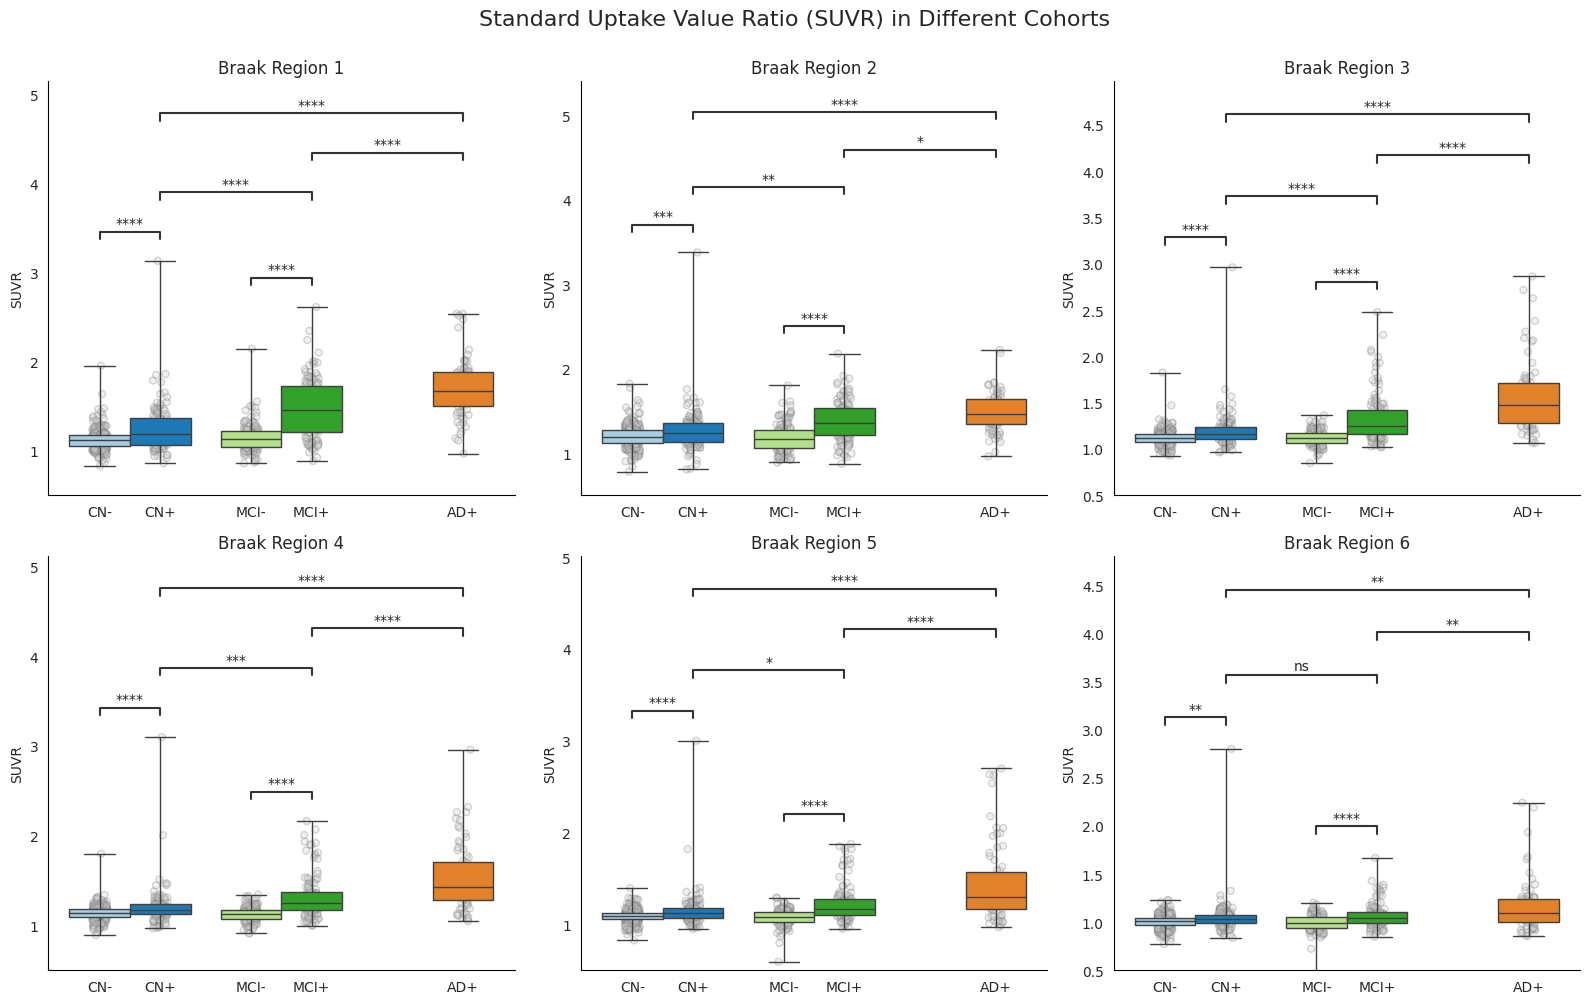

In [141]:
# Identifying Braak regions from the DataFrame columns
Braak_regions = roi_suvr_domino.columns[roi_suvr_domino.columns.str.contains('Braak')]

# Generating pairwise for t-test
pairwiseMatrix = [(("CN", "pos"), ("CN", "neg")), 
                  (("MCI", "pos"), ("MCI", "neg")),
                  (("MCI", "pos"), ("CN", "pos")),
                  (("AD", "pos"), ("CN", "pos")),
                  (("AD", "pos"), ("MCI", "pos"))]

# Create subplots
fig, axs = plt.subplots(figsize=(16, 10), nrows=2, ncols=3)
axs = axs.flatten()

# Creating custom palettes
palette1 = sns.color_palette('Paired',8)[0:4][:] + sns.color_palette('Paired',8)[6:8][:]
palette2 = sns.color_palette(palette='Greys')[1], sns.color_palette(palette='Greys')[1]

# Loop through each Braak region
for i, roi_name in enumerate(Braak_regions):
    # Plot title
    plot_title = f"Braak Region {roi_name.split('_')[1]}"
    
    # Prepare the DataFrame (SUVR + diagnosis data)
    roi_suvr = (
        pd.merge(
            group_roi_suvr[['sid', roi_name]],
            diag_file,
            on='sid'
        )[[roi_name, 'diag', 'BL.AmyloidStatus']]
        .rename(columns={roi_name: 'SUVR'})
        .astype({'SUVR': float})  # Convert SUVR to float
        .set_index('diag')  # Set 'diag' as the index
        .reset_index()  # Reset index to keep 'diag'
    )
    
    ax = axs[i]
    
    # Stripplot (data points)
    sns.stripplot(data= roi_suvr, 
                  x='diag',
                  y='SUVR', 
                  hue='BL.AmyloidStatus',
                  dodge=True,
                  zorder=0,
                  marker="o", linewidth=1, alpha=.3,
                  palette=palette2,
                  ax=ax)

    # Boxplot
    sns.boxplot(
        data= roi_suvr, 
        x='diag', 
        y='SUVR', 
        hue='BL.AmyloidStatus',
        whis=[0, 100],
        width=.8,
        ax=ax)
        
    # Set custom colors for each box
    ax.patches[0].set_facecolor(palette1[0])
    ax.patches[1].set_facecolor(palette1[2])
    ax.patches[2].set_facecolor(palette1[1])
    ax.patches[3].set_facecolor(palette1[3])
    ax.patches[5].set_facecolor(palette1[4])

    # Labels & Titles
    ax.set(ylabel="SUVR")
    ax.set(xlabel="")
    ax.set(title=plot_title)
    ax.set_ylim([0.5,4.6])
    
    # Apply statistical annotation
    annotator = Annotator(ax, pairwiseMatrix, data=roi_suvr, x='diag', y='SUVR', hue='BL.AmyloidStatus')
    annotator.configure(test='t-test_ind', text_format='star', comparisons_correction='bonferroni')
    annotator.apply_and_annotate()
    
    # ------------------------------- Star Threshold  -------------------------------             
    ## ns: 5.00e-02 < p <= 1.00e+00
    ## *: 1.00e-02 < p <= 5.00e-02
    ## **: 1.00e-03 < p <= 1.00e-02
    ## ***: 1.00e-04 < p <= 1.00e-03
    ## ****: p <= 1.00e-04   
    # ------------------------------- Star Threshold  -------------------------------   

    ax.set(ylabel='SUVR')

    # Hide legend
    ax.get_legend().remove()
    
    # Set custom x-tick labels
    ax.set_xticks([0-0.2, 0+0.2, 1-0.2, 1+0.2, 2+0.2])
    ax.set_xticklabels(['CN-', 'CN+', 'MCI-', 'MCI+', 'AD+'])

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Set the color of the remaining spines to black
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')

    # Disable the grid if it is present
    ax.grid(False)          
            
            
# Figure title
fig.suptitle('Standard Uptake Value Ratio (SUVR)' + \
             ' in Different Cohorts',y=1, fontsize=16, ha='center')        

# Save and display plot
plt.tight_layout()
plt.savefig('/mnt/results/SUVR_tauquant.pdf', dpi=1200)
plt.show()